In [11]:
import os
import numpy as np
np.random.seed(123) 
import pandas as pd

from glob import glob
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
# sns.set()
# sns.set_style("whitegrid", {'axes.grid' : False})
%matplotlib inline

from skimage.io import imread
from skimage.transform import resize
from skimage import exposure
from skimage.color import rgb2grey
from skimage.morphology import disk
from skimage.filters import rank


from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras import callbacks
import keras.backend as K
from keras.layers import Dense, Dropout, Activation, \
                         Flatten, Convolution2D, MaxPooling2D, \
                         BatchNormalization, UpSampling2D


In [2]:
# reading pathes 
names_raw = glob('data/Raws/*/*.png')
names_labels = glob('data/Labels/*/*.png')

names_raw.sort()
names_labels.sort()
print("Count raw files: ", len(names_raw))
print("Count labels files: ",len(names_labels))

Count raw files:  119
Count labels files:  119


# Thershold prelearning

In [5]:
names_thr_raw = glob('data/Raws/3/*.png')
names_thr_labels = glob('data/threshold_masks/*.png')

names_thr_raw.sort()
names_thr_labels.sort()
print("Count raw files: ", len(names_thr_raw))
print("Count labels files: ",len(names_thr_labels))

# variable for resizing
sizes = 128

# Function for preparing raw png files
def preparation_raw(x):
    img = imread(x)[:,150:1058,:] # Read and crop image
    img = rgb2grey(img) # to grey image with 1 channel 
    img = resize(img, (sizes,sizes), mode="symmetric") # resizing
    img = np.reshape(img,[sizes,sizes,1]) # reshaping from [h,w] to [h,w,channel] here we have one
    return img
    
    # Uncomment to work with 3 channels pngs
#     img = imread(x)[:,150:1058,:] # Read and crop image
#     img = resize(img, (sizes,sizes), mode="symmetric") # resizing
#     return img

# function for preparing labels files
def preparation_labels(x):
    img = imread(x)[:,150:1058,:] # Read and crop image
    img = rgb2grey(img) # to grey image with 1 channel. Need to make mask
    img = resize(img, (sizes,sizes), mode="symmetric") # resizing
    img[img>0] = 1 # binarization to 0 and 1 view
    img = np.expand_dims(img, axis=2)
    return img

raws_th = np.stack([preparation_raw(i) for i in names_thr_raw], 0)
labels_th = np.stack([preparation_labels(i) for i in names_thr_labels], 0)

print(raws_th.shape)
print(labels_th.shape)

X_train, X_test, y_train,  y_test = train_test_split(raws_th, labels_th, test_size=0.0)

print("RUN MODEL!")

Count raw files:  28
Count labels files:  28


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


(28, 128, 128, 1)
(28, 128, 128, 1)
RUN MODEL!


In [11]:
# Check values inside imgs
# check_img = imread(names_raw[10])
# check_mask = imread(names_labels[10])

# check_mask = np.array(check_mask)
# check_mask = rgb2grey(check_mask)
# check_mask[check_mask>0] = 255
# print(np.unique(check_mask))
# print(check_mask.shape)
# plt.imshow(check_mask)


In [7]:
# variable for resizing
sizes = 512

# Function for preparing raw png files
def preparation_raw(x):
    img = imread(x)[:,150:1058,:] # Read and crop image
    img = rgb2grey(img) # to grey image with 1 channel 
    img = resize(img, (sizes,sizes), mode="symmetric") # resizing
    img = np.reshape(img,[sizes,sizes,1]) # reshaping from [h,w] to [h,w,channel] here we have one
    return img
    
    # Uncomment to work with 3 channels pngs
#     img = imread(x)[:,150:1058,:] # Read and crop image
#     img = resize(img, (sizes,sizes), mode="symmetric") # resizing
#     return img

# function for preparing labels files
def preparation_labels(x):
    img = imread(x)[:,150:1058,:] # Read and crop image
    img = rgb2grey(img) # to grey image with 1 channel. Need to make mask
    img = resize(img, (sizes,sizes), mode="symmetric") # resizing
    img[img>0] = 1 # binarization to 0 and 1 view
    img = np.expand_dims(img, axis=2)
    return img

raws = np.stack([preparation_raw(i) for i in names_raw], 0)
labels = np.stack([preparation_labels(i) for i in names_labels], 0)


# Overfit part
# take only two images and teach NN with it
# raws = np.stack([preparation_raw(i) for i in names_raw[15:19]], 0)
# labels = np.stack([preparation_labels(i) for i in names_labels[15:19]], 0)

print(raws.shape)
print(labels.shape)



/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


(119, 512, 512, 1)
(119, 512, 512, 1)


In [47]:
# print(labels.shape)

# import pandas as pd
# lb = labels[3]
# lb = np.reshape(lb, (sizes*sizes,1))
# lb = pd.DataFrame(lb)
# lb[0].value_counts()

In [28]:
# Separating on train and test parts
X_train, X_test, y_train,  y_test = train_test_split(raws, labels, test_size=0.25)




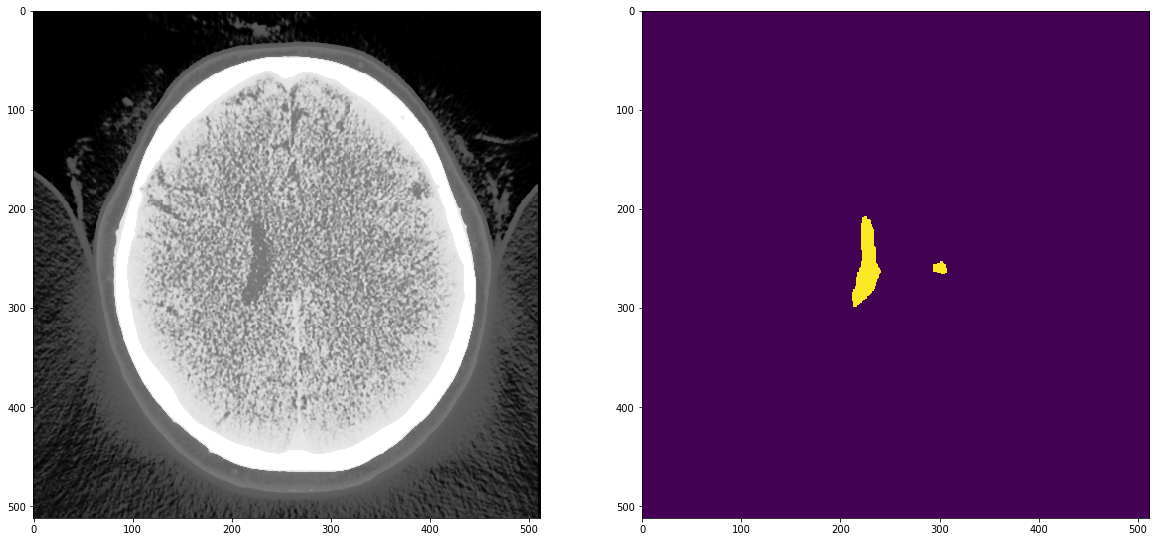

In [30]:
vis_X_train = np.reshape(X_train[2], (sizes,sizes)) # for raw image with 1 channel
# vis_X_train = X_train[2] # for raw image with 3 channels

vis_y_train = np.reshape(y_train[2], (sizes,sizes))

vis_X_train = exposure.equalize_hist(vis_X_train)

# selem = disk(500)
# vis_X_train = rank.equalize(vis_X_train, selem=selem)

vis_X_train.shape
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 10))
ax1.imshow(vis_X_train, cmap=plt.cm.gray)
ax2.imshow(vis_y_train)

In [14]:
# Create a deep nn
model = Sequential()
model.add(Convolution2D(filters=32, 
                        kernel_size=(3, 3), 
                        activation='relu', 
                        input_shape=raws.shape[1:],
                        padding='same'
                        ))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Convolution2D(filters=64, 
                        kernel_size=(3, 3), 
                        activation='relu', 
                        padding='same'
                        ))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Convolution2D(filters=128, 
                        kernel_size=(3, 3), 
                        activation='relu', 
                        padding='same'
                        ))
model.add(UpSampling2D(size=(2,2)))

model.add(Dense(64, activation='relu'))
model.add(Convolution2D(filters=1, 
                        kernel_size=(3, 3), 
                        activation='sigmoid', 
                        input_shape=raws.shape[1:],
                        padding='same'
                        ))
model.add(UpSampling2D(size=(2,2)))


model.compile(loss='binary_crossentropy',
              optimizer='Adam',
              metrics=['accuracy','mse'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 128, 128, 32)      320       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
up_sampling2d_5 (UpSampling2 (None, 64, 64, 128)       0         
_________________________________________________________________
dense_3 (Dense)              (None, 64, 64, 64)        8256      
__________

In [17]:
history = model.fit(X_train, 
                    y_train, 
                    validation_split=0.10,
                    epochs=400, 
                    batch_size=5,
                    
                   )

Train on 82 samples, validate on 10 samples
Epoch 1/400
82/82 [==============================] - 0s 1ms/step - loss: 0.0181 - acc: 0.9930 - mean_squared_error: 0.0051 - val_loss: 0.0190 - val_acc: 0.9931 - val_mean_squared_error: 0.0051
Epoch 2/400
82/82 [==============================] - 0s 1ms/step - loss: 0.0181 - acc: 0.9930 - mean_squared_error: 0.0051 - val_loss: 0.0184 - val_acc: 0.9929 - val_mean_squared_error: 0.0050
Epoch 3/400
82/82 [==============================] - 0s 1ms/step - loss: 0.0182 - acc: 0.9930 - mean_squared_error: 0.0051 - val_loss: 0.0190 - val_acc: 0.9929 - val_mean_squared_error: 0.0051
Epoch 4/400
82/82 [==============================] - 0s 1ms/step - loss: 0.0189 - acc: 0.9928 - mean_squared_error: 0.0053 - val_loss: 0.0250 - val_acc: 0.9922 - val_mean_squared_error: 0.0064
Epoch 5/400
82/82 [==============================] - 0s 1ms/step - loss: 0.0224 - acc: 0.9918 - mean_squared_error: 0.0061 - val_loss: 0.0417 - val_acc: 0.9917 - val_mean_squared_error

82/82 [==============================] - 0s 1ms/step - loss: 0.0171 - acc: 0.9935 - mean_squared_error: 0.0048 - val_loss: 0.0175 - val_acc: 0.9931 - val_mean_squared_error: 0.0048
Epoch 44/400
82/82 [==============================] - 0s 1ms/step - loss: 0.0176 - acc: 0.9933 - mean_squared_error: 0.0049 - val_loss: 0.0179 - val_acc: 0.9931 - val_mean_squared_error: 0.0049
Epoch 45/400
82/82 [==============================] - 0s 1ms/step - loss: 0.0171 - acc: 0.9936 - mean_squared_error: 0.0047 - val_loss: 0.0176 - val_acc: 0.9930 - val_mean_squared_error: 0.0048
Epoch 46/400
82/82 [==============================] - 0s 1ms/step - loss: 0.0172 - acc: 0.9934 - mean_squared_error: 0.0048 - val_loss: 0.0191 - val_acc: 0.9931 - val_mean_squared_error: 0.0051
Epoch 47/400
82/82 [==============================] - 0s 1ms/step - loss: 0.0176 - acc: 0.9933 - mean_squared_error: 0.0049 - val_loss: 0.0176 - val_acc: 0.9932 - val_mean_squared_error: 0.0048
Epoch 48/400
82/82 [=======================

82/82 [==============================] - 0s 1ms/step - loss: 0.0178 - acc: 0.9933 - mean_squared_error: 0.0049 - val_loss: 0.0184 - val_acc: 0.9932 - val_mean_squared_error: 0.0050
Epoch 128/400
82/82 [==============================] - 0s 1ms/step - loss: 0.0170 - acc: 0.9936 - mean_squared_error: 0.0047 - val_loss: 0.0170 - val_acc: 0.9937 - val_mean_squared_error: 0.0046
Epoch 129/400
82/82 [==============================] - 0s 1ms/step - loss: 0.0156 - acc: 0.9942 - mean_squared_error: 0.0043 - val_loss: 0.0173 - val_acc: 0.9936 - val_mean_squared_error: 0.0046
Epoch 130/400
82/82 [==============================] - 0s 1ms/step - loss: 0.0154 - acc: 0.9943 - mean_squared_error: 0.0042 - val_loss: 0.0165 - val_acc: 0.9938 - val_mean_squared_error: 0.0045
Epoch 131/400
82/82 [==============================] - 0s 1ms/step - loss: 0.0152 - acc: 0.9944 - mean_squared_error: 0.0042 - val_loss: 0.0166 - val_acc: 0.9937 - val_mean_squared_error: 0.0045
Epoch 132/400
82/82 [==================

82/82 [==============================] - 0s 1ms/step - loss: 0.0137 - acc: 0.9949 - mean_squared_error: 0.0037 - val_loss: 0.0157 - val_acc: 0.9942 - val_mean_squared_error: 0.0042
Epoch 212/400
82/82 [==============================] - 0s 1ms/step - loss: 0.0137 - acc: 0.9949 - mean_squared_error: 0.0037 - val_loss: 0.0158 - val_acc: 0.9940 - val_mean_squared_error: 0.0042
Epoch 213/400
82/82 [==============================] - 0s 1ms/step - loss: 0.0142 - acc: 0.9948 - mean_squared_error: 0.0038 - val_loss: 0.0155 - val_acc: 0.9942 - val_mean_squared_error: 0.0041
Epoch 214/400
82/82 [==============================] - 0s 1ms/step - loss: 0.0138 - acc: 0.9949 - mean_squared_error: 0.0038 - val_loss: 0.0153 - val_acc: 0.9943 - val_mean_squared_error: 0.0041
Epoch 215/400
82/82 [==============================] - 0s 1ms/step - loss: 0.0136 - acc: 0.9950 - mean_squared_error: 0.0037 - val_loss: 0.0156 - val_acc: 0.9942 - val_mean_squared_error: 0.0042
Epoch 216/400
82/82 [==================

82/82 [==============================] - 0s 1ms/step - loss: 0.0118 - acc: 0.9956 - mean_squared_error: 0.0032 - val_loss: 0.0145 - val_acc: 0.9947 - val_mean_squared_error: 0.0038
Epoch 296/400
82/82 [==============================] - 0s 1ms/step - loss: 0.0117 - acc: 0.9957 - mean_squared_error: 0.0032 - val_loss: 0.0147 - val_acc: 0.9947 - val_mean_squared_error: 0.0039
Epoch 297/400
82/82 [==============================] - 0s 1ms/step - loss: 0.0116 - acc: 0.9957 - mean_squared_error: 0.0031 - val_loss: 0.0149 - val_acc: 0.9946 - val_mean_squared_error: 0.0039
Epoch 298/400
82/82 [==============================] - 0s 1ms/step - loss: 0.0117 - acc: 0.9957 - mean_squared_error: 0.0031 - val_loss: 0.0153 - val_acc: 0.9947 - val_mean_squared_error: 0.0040
Epoch 299/400
82/82 [==============================] - 0s 1ms/step - loss: 0.0116 - acc: 0.9957 - mean_squared_error: 0.0031 - val_loss: 0.0146 - val_acc: 0.9947 - val_mean_squared_error: 0.0038
Epoch 300/400
82/82 [==================

82/82 [==============================] - 0s 1ms/step - loss: 0.0104 - acc: 0.9962 - mean_squared_error: 0.0028 - val_loss: 0.0143 - val_acc: 0.9949 - val_mean_squared_error: 0.0037
Epoch 380/400
82/82 [==============================] - 0s 1ms/step - loss: 0.0102 - acc: 0.9962 - mean_squared_error: 0.0028 - val_loss: 0.0140 - val_acc: 0.9948 - val_mean_squared_error: 0.0037
Epoch 381/400
82/82 [==============================] - 0s 1ms/step - loss: 0.0103 - acc: 0.9962 - mean_squared_error: 0.0028 - val_loss: 0.0156 - val_acc: 0.9948 - val_mean_squared_error: 0.0039
Epoch 382/400
82/82 [==============================] - 0s 1ms/step - loss: 0.0104 - acc: 0.9962 - mean_squared_error: 0.0028 - val_loss: 0.0141 - val_acc: 0.9951 - val_mean_squared_error: 0.0036
Epoch 383/400
82/82 [==============================] - 0s 1ms/step - loss: 0.0102 - acc: 0.9962 - mean_squared_error: 0.0028 - val_loss: 0.0144 - val_acc: 0.9950 - val_mean_squared_error: 0.0037
Epoch 384/400
82/82 [==================

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<Figure size 432x288 with 0 Axes>

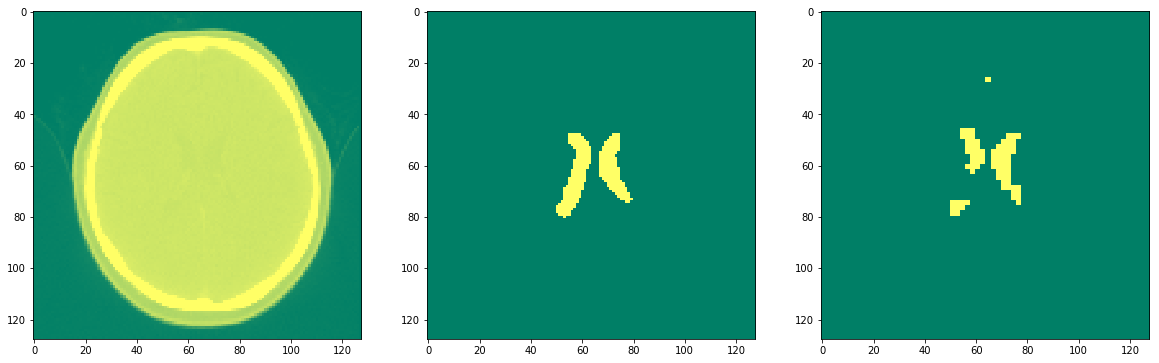

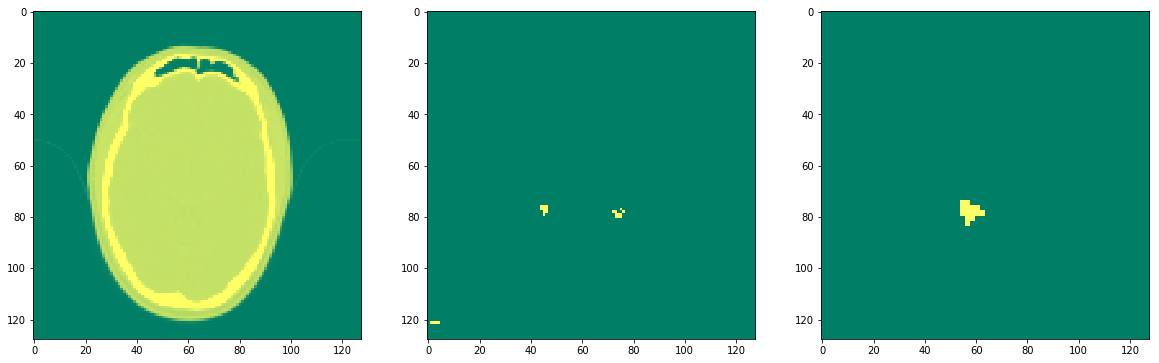

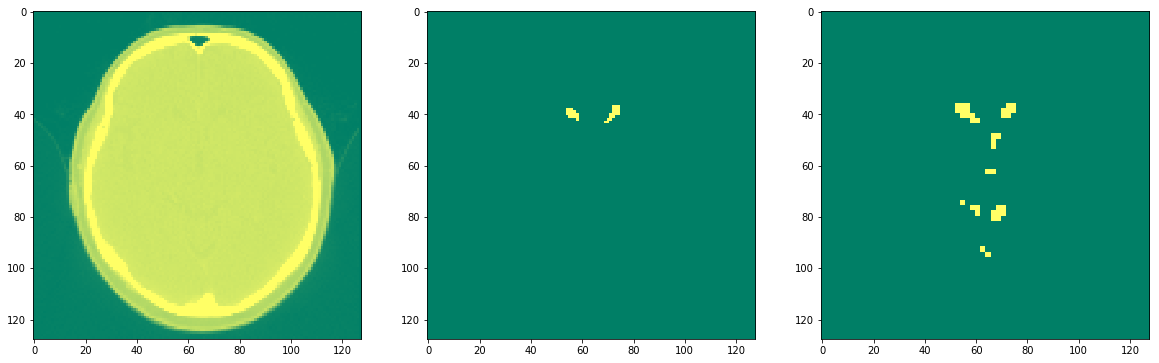

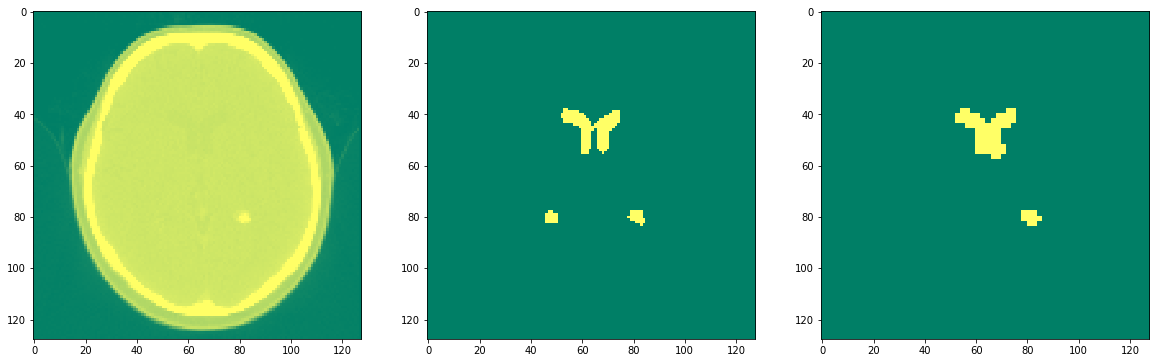

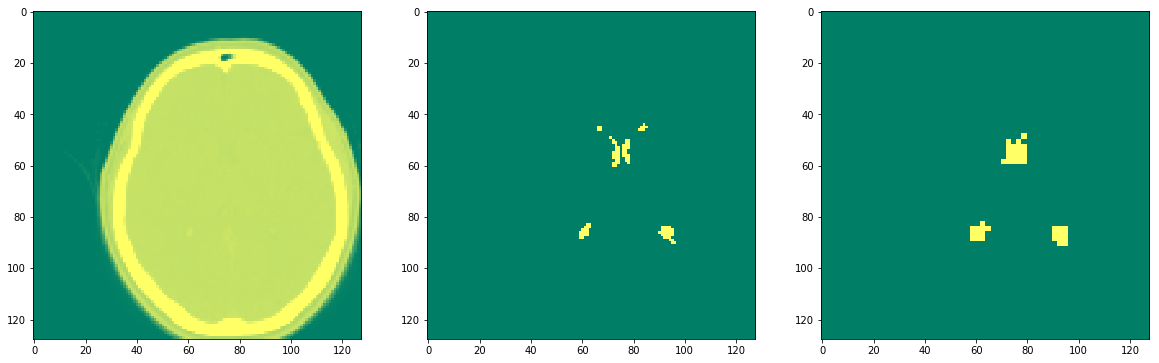

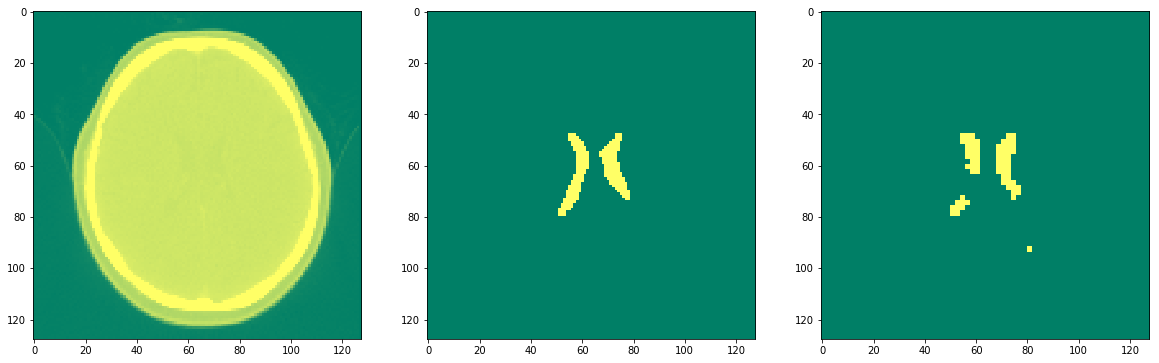

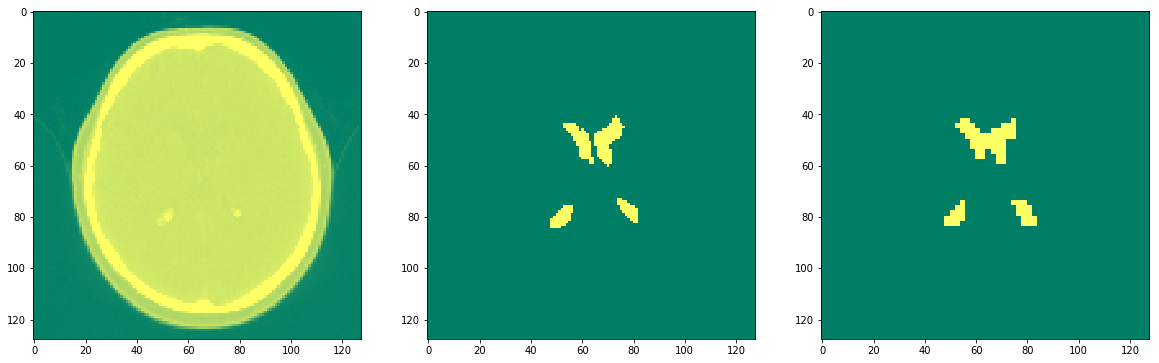

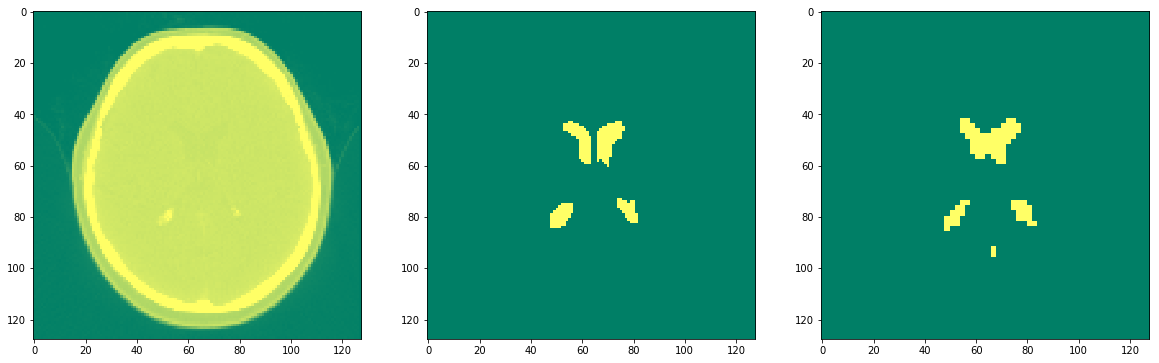

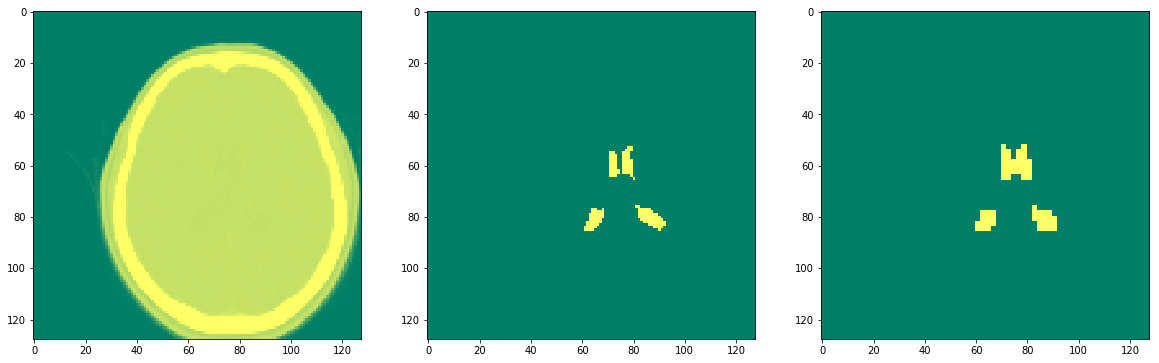

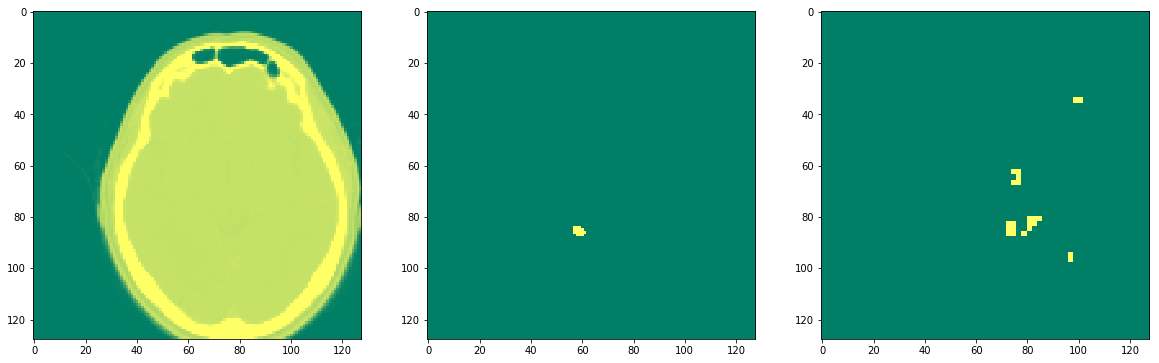

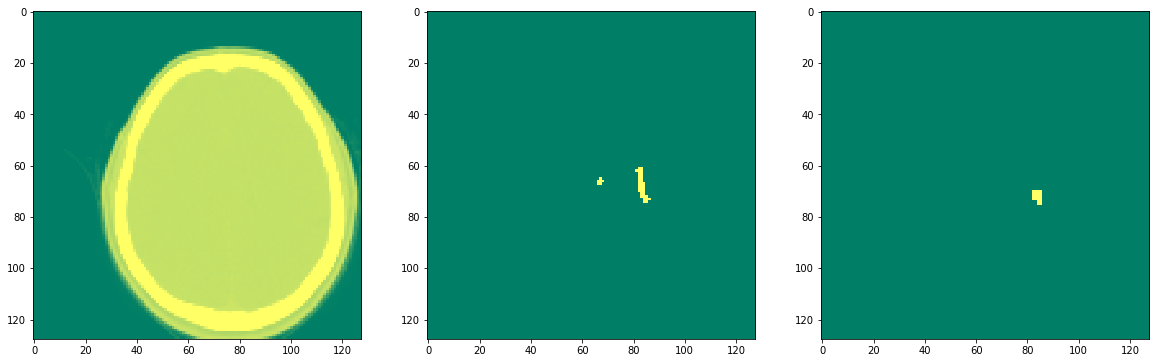

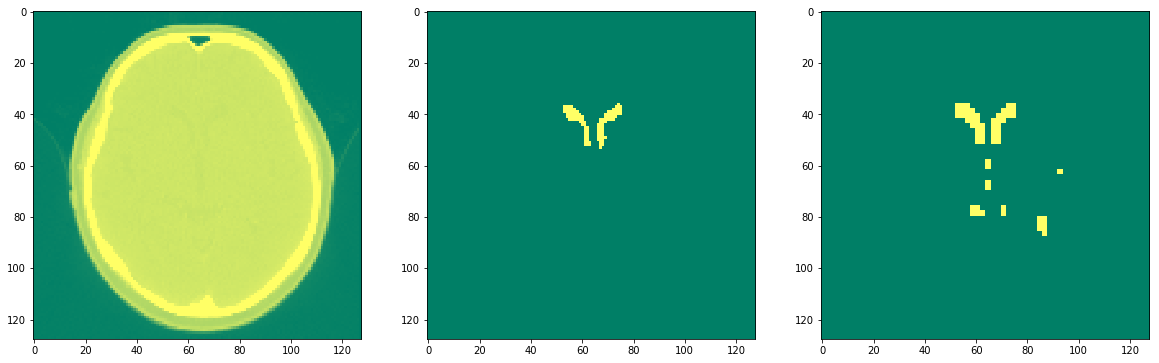

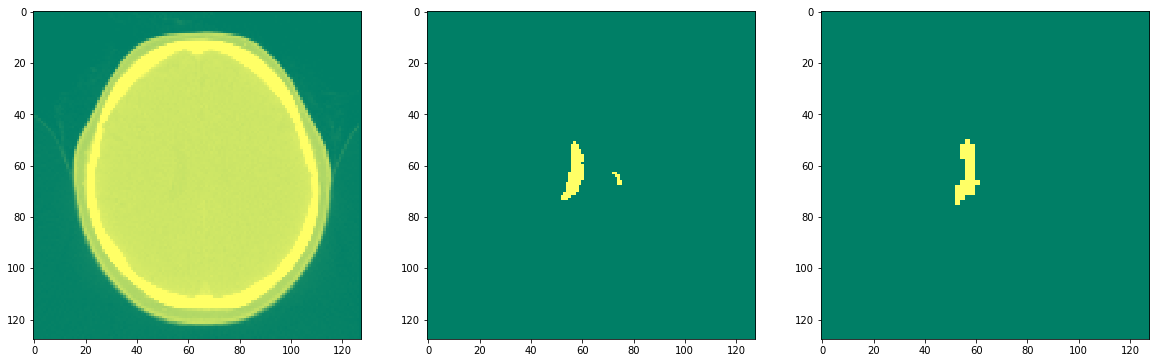

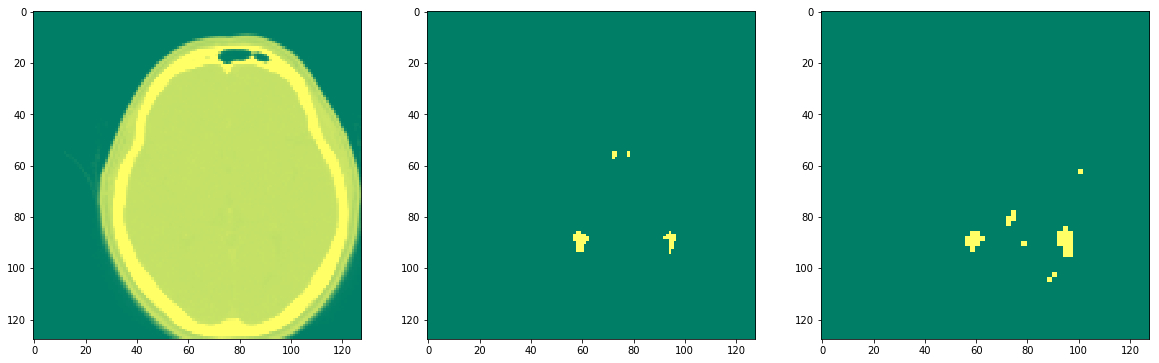

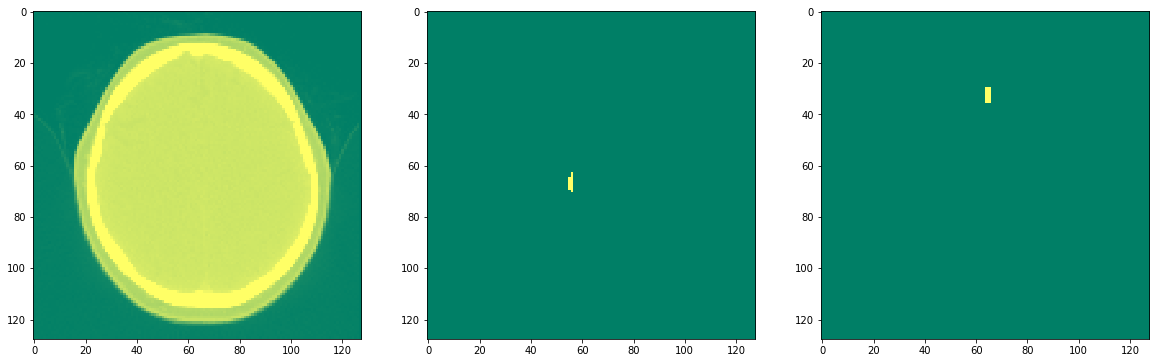

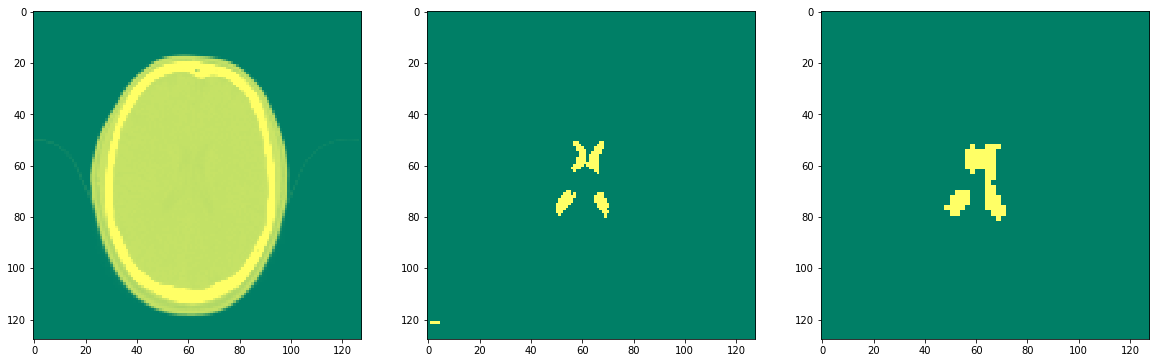

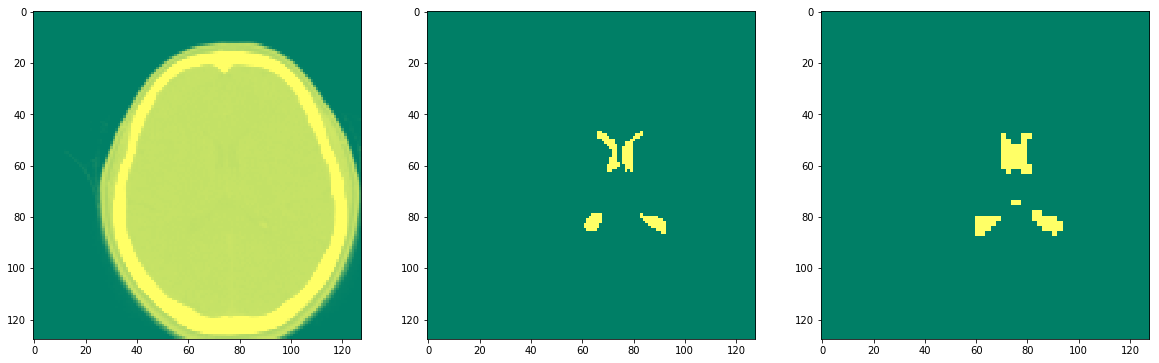

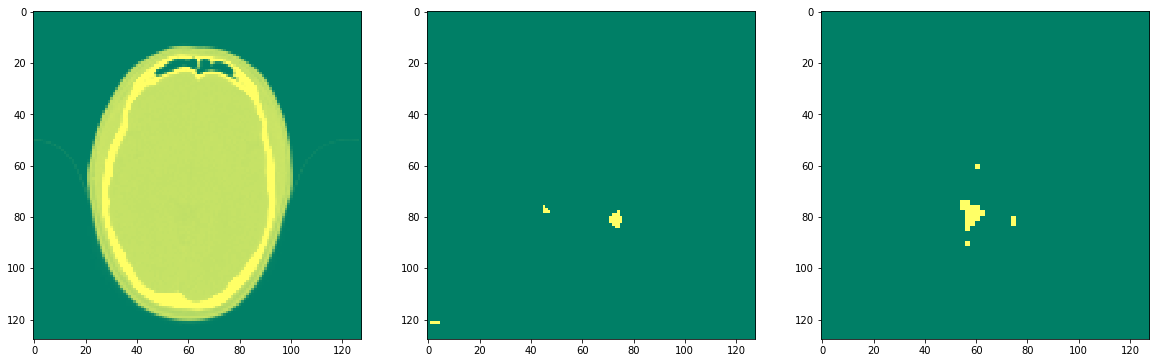

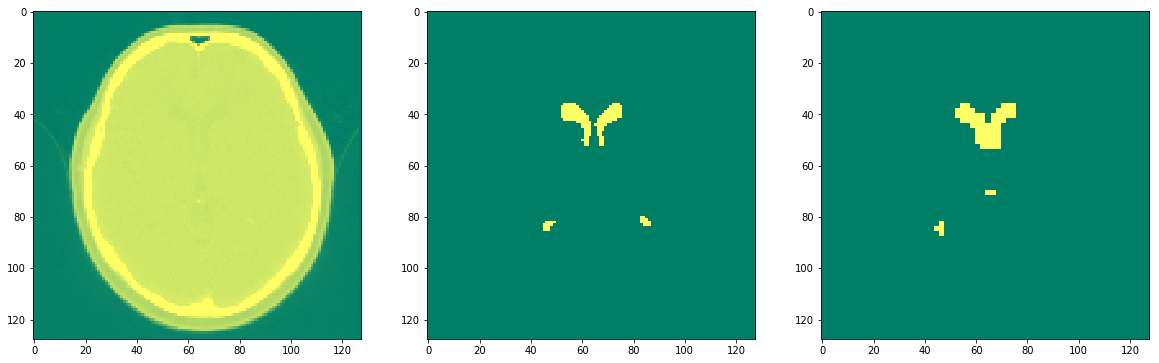

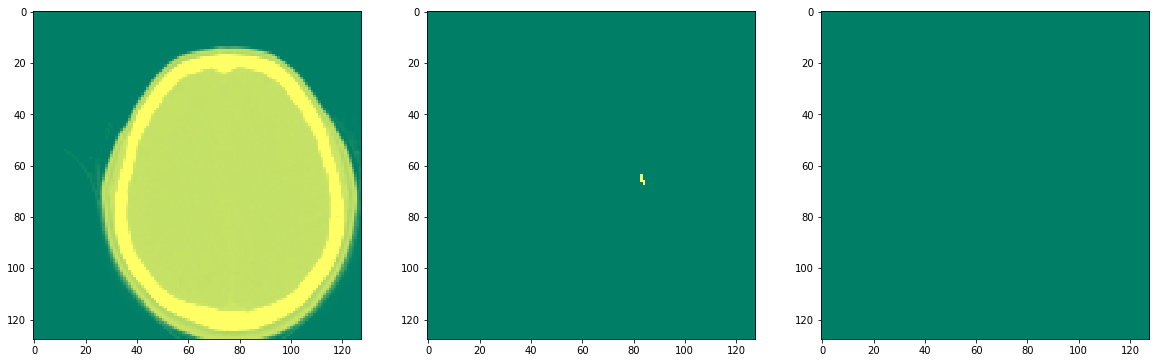

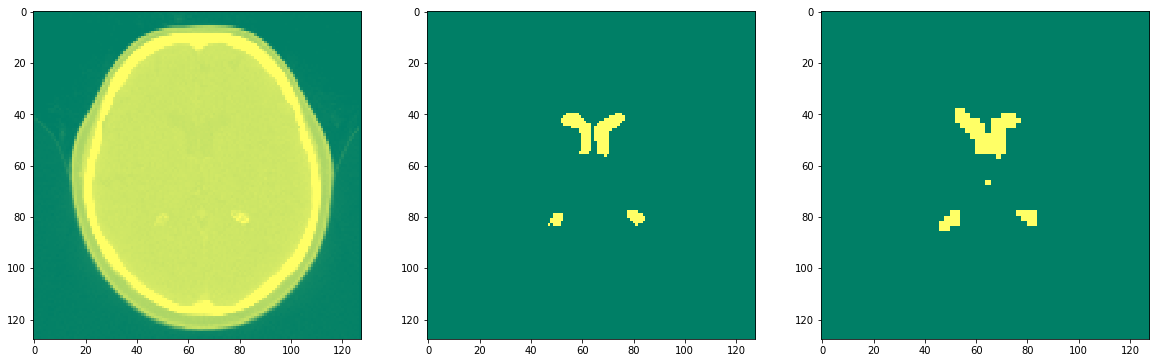

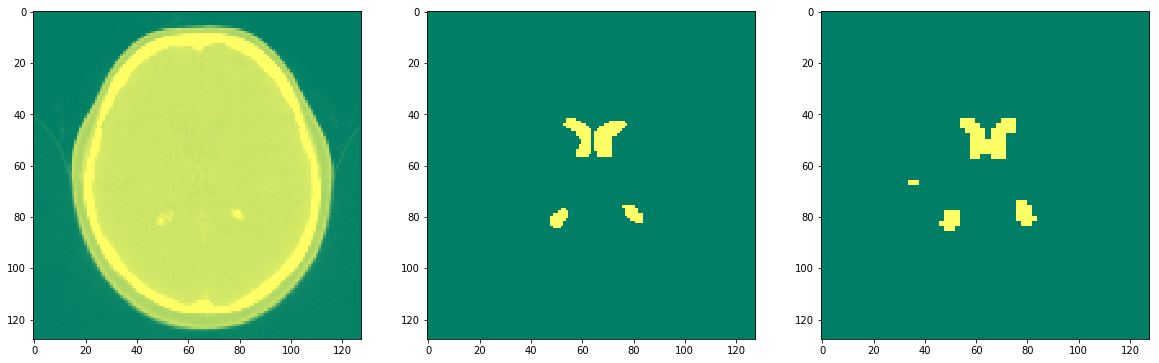

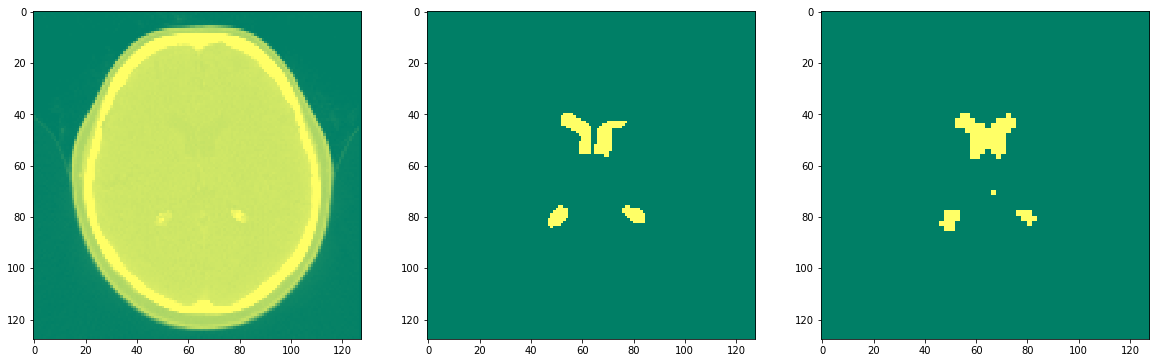

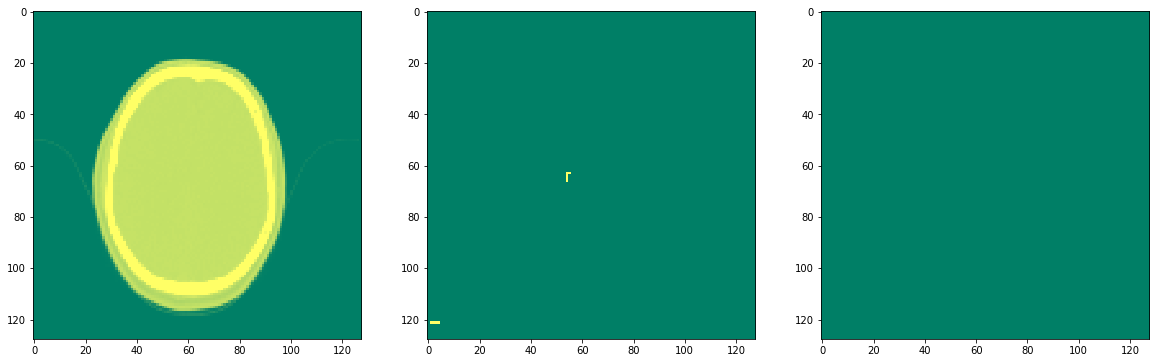

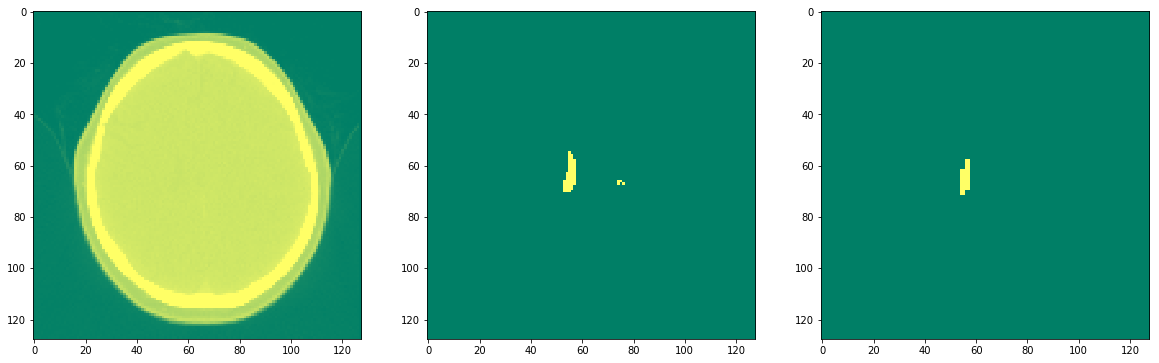

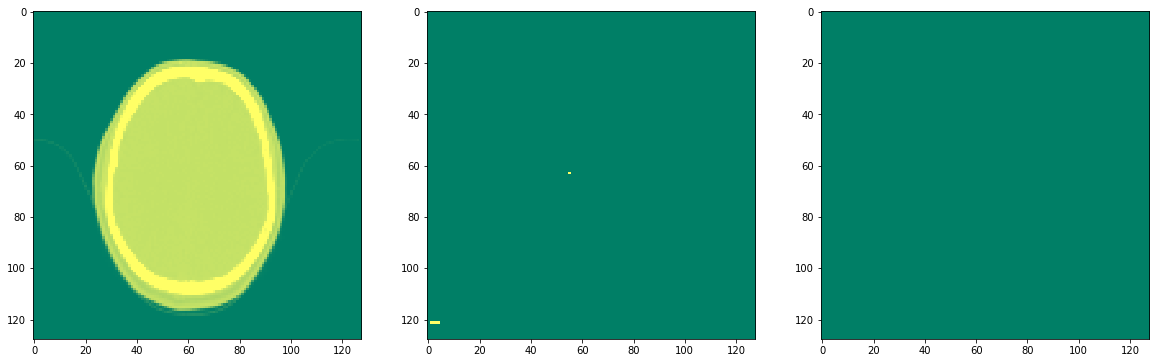

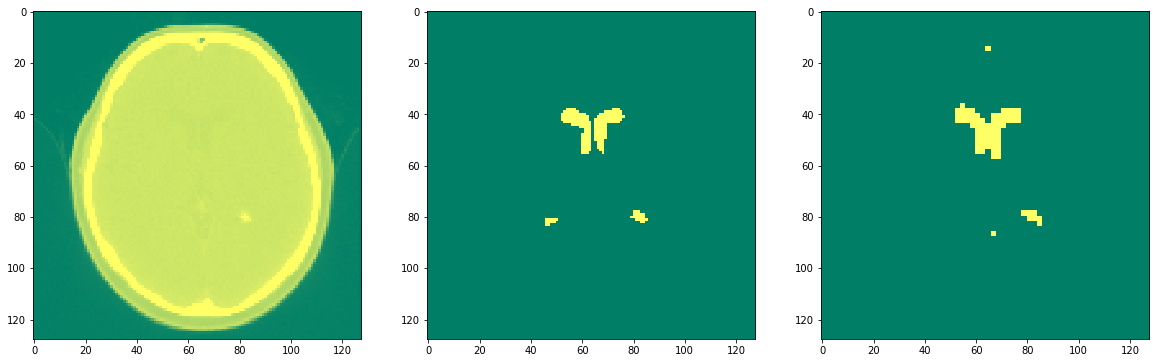

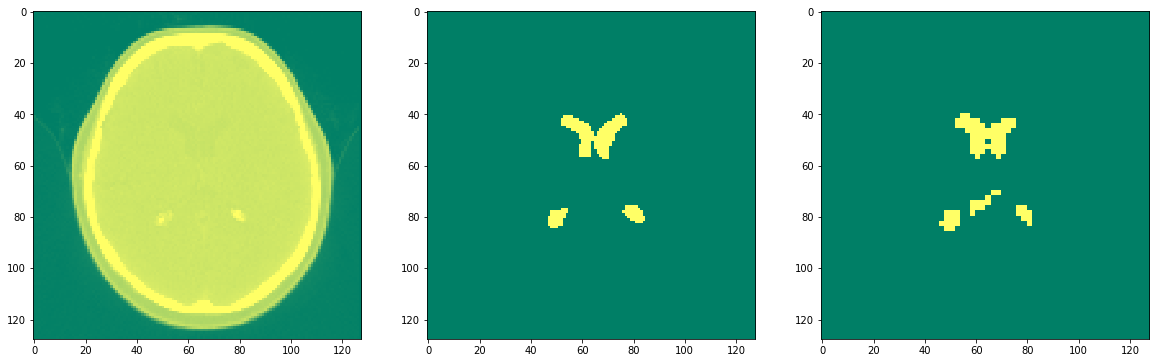

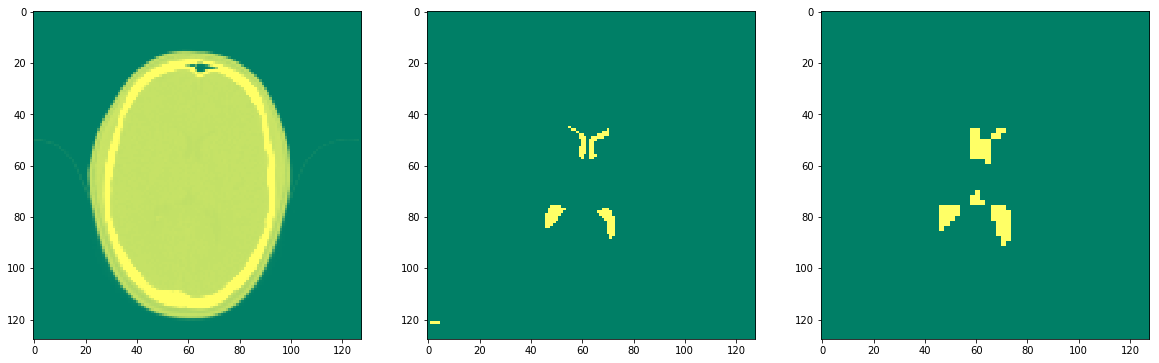

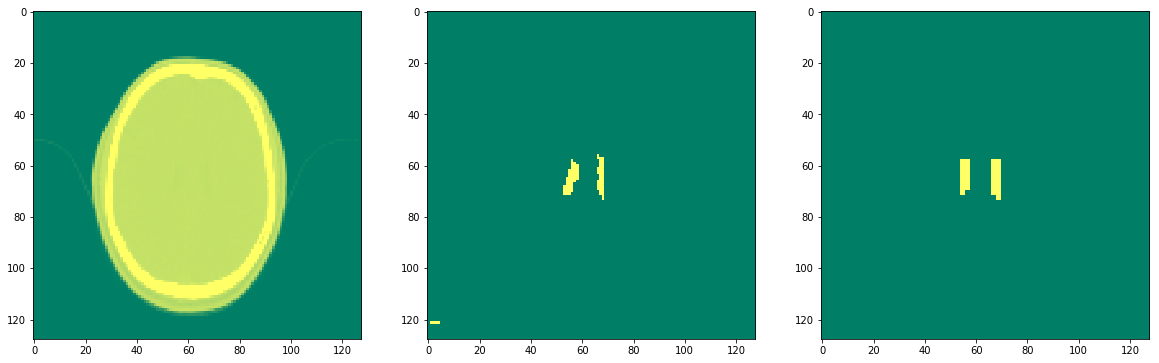

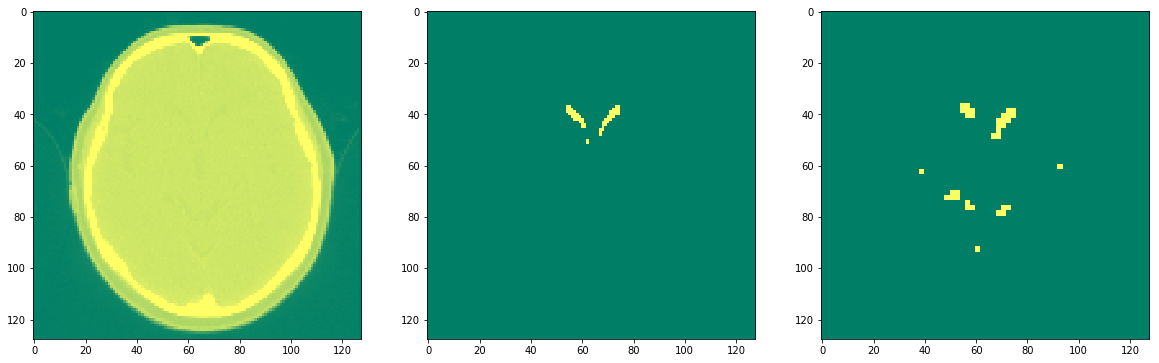

In [18]:

# sns.set_style("ticks", {'axes.grid' : False})
# sns.set_context("poster")
# sns.set_palette("Reds")

# plt.set_cmap('inferno')
# plt.set_cmap('magma')
# plt.set_cmap('plasma')
# plt.set_cmap('viridis')
# plt.set_cmap('BrBG')
# plt.set_cmap('PiYG')
# plt.set_cmap('PRGn')
# plt.set_cmap('PuOr')
# plt.set_cmap('RdBu')
# plt.set_cmap('RdGy')
# plt.set_cmap('RdYlBu')
# plt.set_cmap('RdYlGn')
# plt.set_cmap('Spectral')
# plt.set_cmap('autumn')
# plt.set_cmap('bone')
# plt.set_cmap('cool')
# plt.set_cmap('hot')
# plt.set_cmap('hsv')
# plt.set_cmap('jet')
# plt.set_cmap('pink')
# plt.set_cmap('prism')
# plt.set_cmap('spring')
# plt.set_cmap('summer')
# plt.set_cmap('winter')
# plt.set_cmap('flag')


# plt.set_cmap('autumn')
# plt.set_cmap('bone')
# plt.set_cmap('pink')
# plt.set_cmap('prism')
# plt.set_cmap('spring')
plt.set_cmap('summer')



for x in range(len(X_test-10)):
    
    img_in_test_set = x
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 10))
    x_tm = X_test[img_in_test_set]
    x_tm = np.reshape(x_tm, [sizes,sizes])
    y_tm = y_test[img_in_test_set]
    y_tm = np.reshape(y_tm, [sizes,sizes])

    pred_tm = model.predict(X_test[img_in_test_set:img_in_test_set+1])
    # pred_tm = pred_tm[0]

#     print(pred_tm.shape)
#     print(np.unique(pred_tm))
    pred_tm = np.reshape(pred_tm[0], [sizes,sizes])
    pred_tm[pred_tm > 0.15] = 1
    pred_tm[pred_tm < 0.15] = 0
    ax1.imshow(x_tm)
    ax2.imshow(y_tm)
    ax3.imshow(pred_tm)
    
    fig.savefig("ex" + str(x) + ".png")

(92, 128, 128, 1)


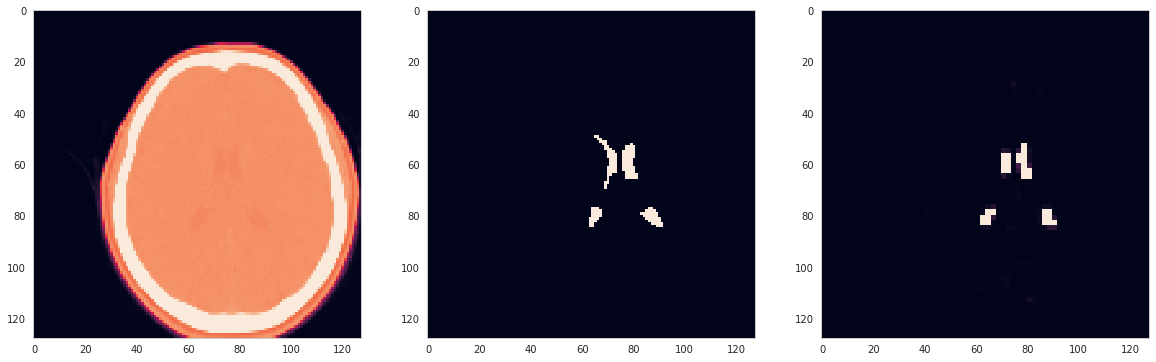

In [93]:
## Overfit tests

img_in_test_set = 8
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 10))
x_tm = X_train[img_in_test_set]
x_tm = np.reshape(x_tm, [sizes,sizes])
y_tm = y_train[img_in_test_set]
y_tm = np.reshape(y_tm, [sizes,sizes])

pred_tm = model.predict(X_train)
print(pred_tm.shape)
pred_tm[pred_tm > 0.2] = 1

pred_tm = np.reshape(pred_tm[img_in_test_set], [sizes,sizes])

ax1.imshow(x_tm)
ax2.imshow(y_tm)
ax3.imshow(pred_tm)

In [104]:
np.amax(pred_tm)

9.995139e-08

In [137]:
model.save("v0.1.h5")

# Finetune test

In [9]:
model = keras.models.load_model("v0.2-finetune.h5")

In [49]:
history = model.fit(X_train, 
                    y_train, 
                    epochs=550, 
                    batch_size=10,
                   )

Epoch 1/550
46/46 [==============================] - 1s 15ms/step - loss: 0.0550 - acc: 0.9890 - mean_squared_error: 0.0110
Epoch 2/550
46/46 [==============================] - 1s 15ms/step - loss: 0.0500 - acc: 0.9881 - mean_squared_error: 0.0113
Epoch 3/550
46/46 [==============================] - 1s 15ms/step - loss: 0.0460 - acc: 0.9881 - mean_squared_error: 0.0109
Epoch 4/550
46/46 [==============================] - 1s 15ms/step - loss: 0.0456 - acc: 0.9882 - mean_squared_error: 0.0103
Epoch 5/550
46/46 [==============================] - 1s 15ms/step - loss: 0.0475 - acc: 0.9881 - mean_squared_error: 0.0108
Epoch 6/550
46/46 [==============================] - 1s 15ms/step - loss: 0.0559 - acc: 0.9891 - mean_squared_error: 0.0117
Epoch 7/550
46/46 [==============================] - 1s 15ms/step - loss: 0.0507 - acc: 0.9881 - mean_squared_error: 0.0114
Epoch 8/550
46/46 [==============================] - 1s 15ms/step - loss: 0.0468 - acc: 0.9881 - mean_squared_error: 0.0111
Epoch 9/

46/46 [==============================] - 1s 15ms/step - loss: 0.0400 - acc: 0.9881 - mean_squared_error: 0.0098
Epoch 132/550
46/46 [==============================] - 1s 15ms/step - loss: 0.0507 - acc: 0.9888 - mean_squared_error: 0.0115
Epoch 133/550
46/46 [==============================] - 1s 15ms/step - loss: 0.0589 - acc: 0.9881 - mean_squared_error: 0.0116
Epoch 134/550
46/46 [==============================] - 1s 15ms/step - loss: 0.0463 - acc: 0.9881 - mean_squared_error: 0.0110
Epoch 135/550
46/46 [==============================] - 1s 14ms/step - loss: 0.0429 - acc: 0.9881 - mean_squared_error: 0.0105
Epoch 136/550
46/46 [==============================] - 1s 14ms/step - loss: 0.0459 - acc: 0.9891 - mean_squared_error: 0.0102
Epoch 137/550
46/46 [==============================] - 1s 14ms/step - loss: 0.0483 - acc: 0.9881 - mean_squared_error: 0.0111
Epoch 138/550
46/46 [==============================] - 1s 15ms/step - loss: 0.0458 - acc: 0.9882 - mean_squared_error: 0.0100
Epoch 

46/46 [==============================] - 1s 15ms/step - loss: 0.0436 - acc: 0.9882 - mean_squared_error: 0.0106
Epoch 262/550
46/46 [==============================] - 1s 15ms/step - loss: 0.0422 - acc: 0.9883 - mean_squared_error: 0.0098
Epoch 263/550
46/46 [==============================] - 1s 15ms/step - loss: 0.0368 - acc: 0.9887 - mean_squared_error: 0.0089
Epoch 264/550
46/46 [==============================] - 1s 15ms/step - loss: 0.0735 - acc: 0.9875 - mean_squared_error: 0.0143
Epoch 265/550
46/46 [==============================] - 1s 15ms/step - loss: 0.0492 - acc: 0.9881 - mean_squared_error: 0.0112
Epoch 266/550
46/46 [==============================] - 1s 15ms/step - loss: 0.0443 - acc: 0.9881 - mean_squared_error: 0.0107
Epoch 267/550
46/46 [==============================] - 1s 15ms/step - loss: 0.0430 - acc: 0.9882 - mean_squared_error: 0.0106
Epoch 268/550
46/46 [==============================] - 1s 15ms/step - loss: 0.0383 - acc: 0.9881 - mean_squared_error: 0.0095
Epoch 

46/46 [==============================] - 1s 15ms/step - loss: 0.0423 - acc: 0.9882 - mean_squared_error: 0.0103
Epoch 392/550
46/46 [==============================] - 1s 15ms/step - loss: 0.0400 - acc: 0.9897 - mean_squared_error: 0.0087
Epoch 393/550
46/46 [==============================] - 1s 15ms/step - loss: 0.0475 - acc: 0.9882 - mean_squared_error: 0.0109
Epoch 394/550
46/46 [==============================] - 1s 15ms/step - loss: 0.0433 - acc: 0.9892 - mean_squared_error: 0.0094
Epoch 395/550
46/46 [==============================] - 1s 15ms/step - loss: 0.0403 - acc: 0.9893 - mean_squared_error: 0.0092
Epoch 396/550
46/46 [==============================] - 1s 15ms/step - loss: 0.0488 - acc: 0.9891 - mean_squared_error: 0.0104
Epoch 397/550
46/46 [==============================] - 1s 15ms/step - loss: 0.0433 - acc: 0.9882 - mean_squared_error: 0.0106
Epoch 398/550
46/46 [==============================] - 1s 15ms/step - loss: 0.0389 - acc: 0.9884 - mean_squared_error: 0.0094
Epoch 

46/46 [==============================] - 1s 19ms/step - loss: 0.0566 - acc: 0.9882 - mean_squared_error: 0.0114
Epoch 522/550
46/46 [==============================] - 1s 18ms/step - loss: 0.0434 - acc: 0.9883 - mean_squared_error: 0.0105
Epoch 523/550
46/46 [==============================] - 1s 19ms/step - loss: 0.0391 - acc: 0.9884 - mean_squared_error: 0.0097
Epoch 524/550
46/46 [==============================] - 1s 18ms/step - loss: 0.0420 - acc: 0.9885 - mean_squared_error: 0.0099
Epoch 525/550
46/46 [==============================] - 1s 18ms/step - loss: 0.0415 - acc: 0.9884 - mean_squared_error: 0.0095
Epoch 526/550
46/46 [==============================] - 1s 18ms/step - loss: 0.0672 - acc: 0.9883 - mean_squared_error: 0.0135
Epoch 527/550
46/46 [==============================] - 1s 20ms/step - loss: 0.0522 - acc: 0.9882 - mean_squared_error: 0.0112
Epoch 528/550
46/46 [==============================] - 1s 18ms/step - loss: 0.0380 - acc: 0.9883 - mean_squared_error: 0.0097
Epoch 

(1, 128, 128, 1)
[0.0000000e+00 2.0993473e-38 2.4222957e-38 ... 2.7069822e-01 2.7224839e-01
 2.8322077e-01]


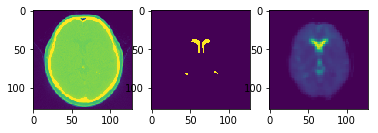

In [48]:
# Variable for choosing test image
img_in_test_set = 5

# Plotting comparing
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
x_tm = X_test[img_in_test_set]
x_tm = np.reshape(x_tm, [sizes,sizes])
y_tm = y_test[img_in_test_set]
y_tm = np.reshape(y_tm, [sizes,sizes])

pred_tm = model.predict(X_test[img_in_test_set:img_in_test_set+1])
# pred_tm = pred_tm[0]

print(pred_tm.shape)
print(np.unique(pred_tm))
pred_tm = np.reshape(pred_tm[0], [sizes,sizes])
pred_tm[pred_tm > 0.9] = 1
ax1.imshow(x_tm)
ax2.imshow(y_tm)
ax3.imshow(pred_tm)

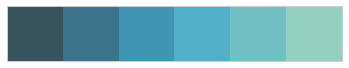

In [101]:
sns.palplot(sns.color_palette("GnBu_d"))